In [4]:
doCompare <- function(dsFileName, mcmcFileName) {
    dfs <- read.table(paste0("simulator/", dsFileName), header=T)
    df <- read.table(paste0("operators/", mcmcFileName), header=T)

    # Remove 10% for burnin
    N <- dim(df)[1]
    df <- df[-(1:ceiling(0.1*N)),]
    
    # Tree age/length plot
    
    maxLength <- max(quantile(df$network.totalLength, probs=0.99),
                     quantile(dfs$network.totalLength, probs=0.99),
                     quantile(df$network.height, probs=0.99),
                     quantile(dfs$network.height, probs=0.99))
    
    maxDensity <- max(density(dfs$network.height)$y,
                      density(df$network.height)$y,
                      density(dfs$network.totalLength)$y,
                      density(df$network.totalLength)$y)
    
    plot(density(df$network.height), 'l', col='red', lwd=2, lty=2,
         xlim=c(0,maxLength), ylim=c(0,maxDensity),
         xlab="Statistic", ylab="Density",
         main="")
    lines(density(dfs$network.height), col='blue', lwd=2, lty=2)
    lines(density(df$network.totalLength), col='red', lwd=2)
    lines(density(dfs$network.totalLength), col='blue', lwd=2)
    legend("topright", inset=0.05,
       c("MCMC", "Direct simulation","Network length", "Network height"),
       lty=c(1,1,1,2), lwd=2, col=c("red","blue","black","black"))
    
    # Network node count plot
    
    maxCount <- max(df$network.reassortmentNodeCount, dfs$network.reassortmentNodeCount)+1
    h <- hist(df$network.reassortmentNodeCount, plot=F,
              breaks=seq(-0.5,maxCount+0.5,by=1))
    hs <- hist(dfs$network.reassortmentNodeCount, plot=F,
               breaks=seq(-0.5,maxCount+0.5,by=1))
    
    plot(h$mids, h$density, 'o', col='red', lwd=4,
        xlab="Reassortment Count",
        ylab="Posterior probability")
    lines(hs$mids, hs$density, 'o', col='blue', lwd=2)
    
    legend("topright", inset=0.04,
          c("MCMC", "Direct simulation"), lty=1, pch=1, lwd=2,
          col=c("red","blue"))
}

Simulator Validation
-------------------

When reassortment is turned off, the simulator should draw trees from a standard coalescent distribution.  We can test this by comparing tree heights and lengths between our simulator and the regular RandomTree simulator under various population functions.

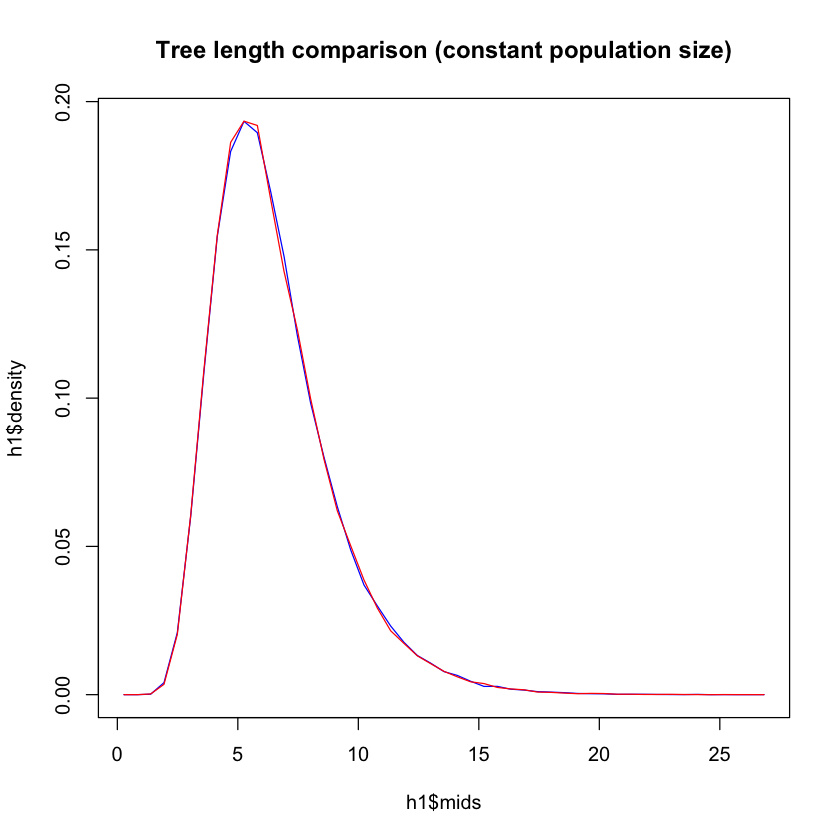

In [16]:
df <- read.table("simulator/simulate_without_reassortment.log", header=T)

maxLength <- max(df$simulated_network.totalLength,
                df$simulated_tree.treeLength)
breaks <- seq(0, maxLength, length.out=50)

h1 <- hist(df$simulated_network.totalLength, plot=F,
          breaks=breaks)
h2 <- hist(df$simulated_tree.treeLength, plot=F,
          breaks=breaks)

plot(h1$mids, h1$density, 'l', col='blue',
    main="Tree length comparison (constant population size)")
lines(h2$mids, h2$density, col='red')

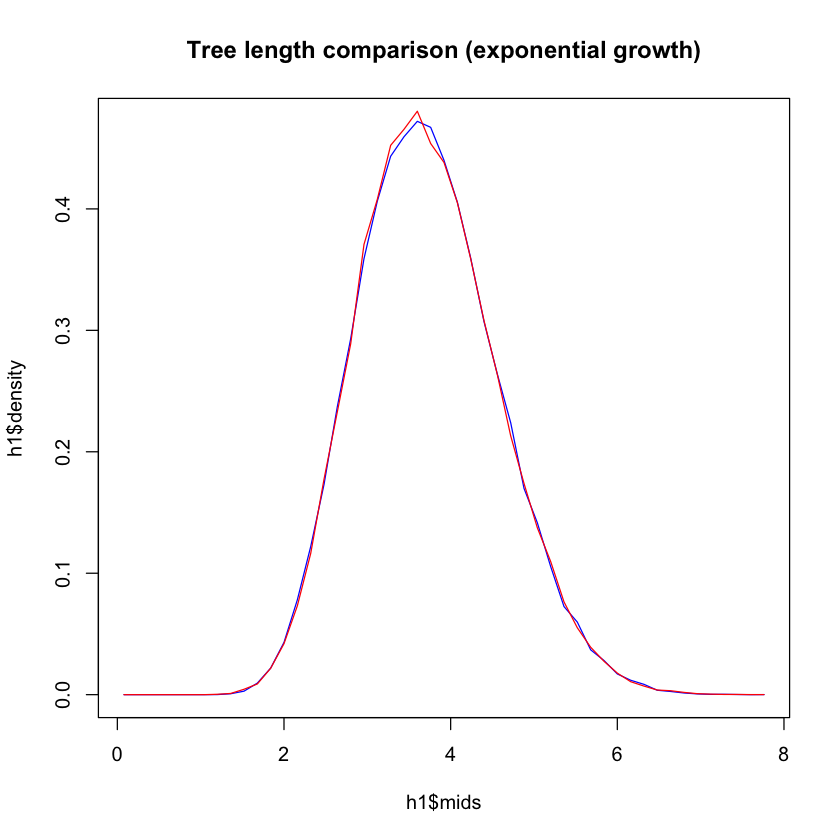

In [17]:
df <- read.table("simulator/simulate_without_reassortment_expGrowth.log", header=T)

maxLength <- max(df$simulated_network.totalLength,
                df$simulated_tree.treeLength)
breaks <- seq(0, maxLength, length.out=50)

h1 <- hist(df$simulated_network.totalLength, plot=F,
          breaks=breaks)
h2 <- hist(df$simulated_tree.treeLength, plot=F,
          breaks=breaks)

plot(h1$mids, h1$density, 'l', col='blue',
    main="Tree length comparison (exponential growth)")
lines(h2$mids, h2$density, col='red')

## Divert setment operator

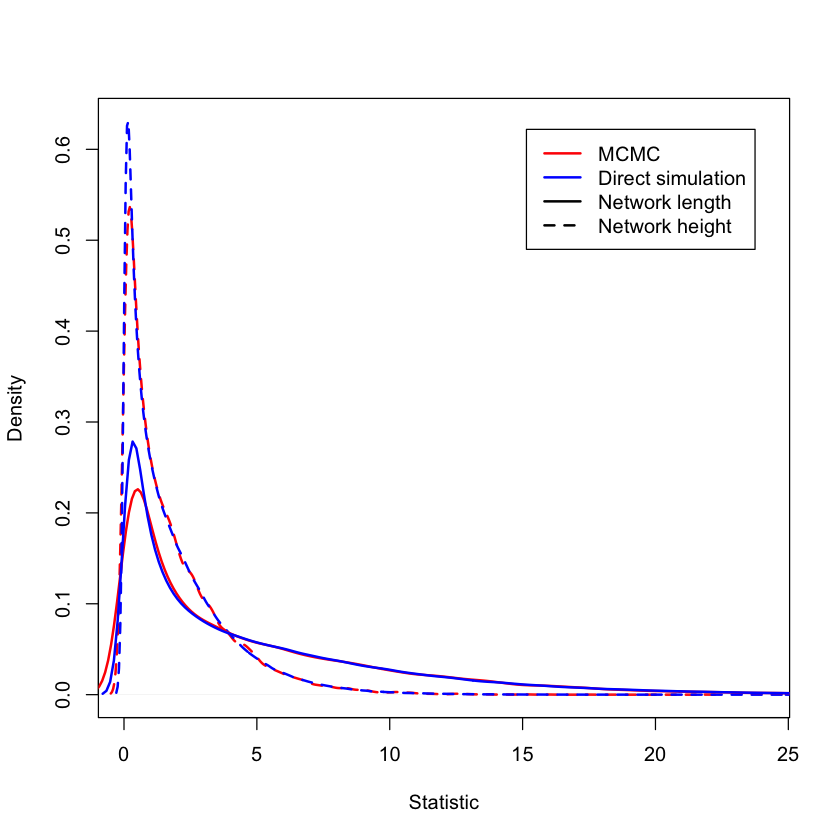

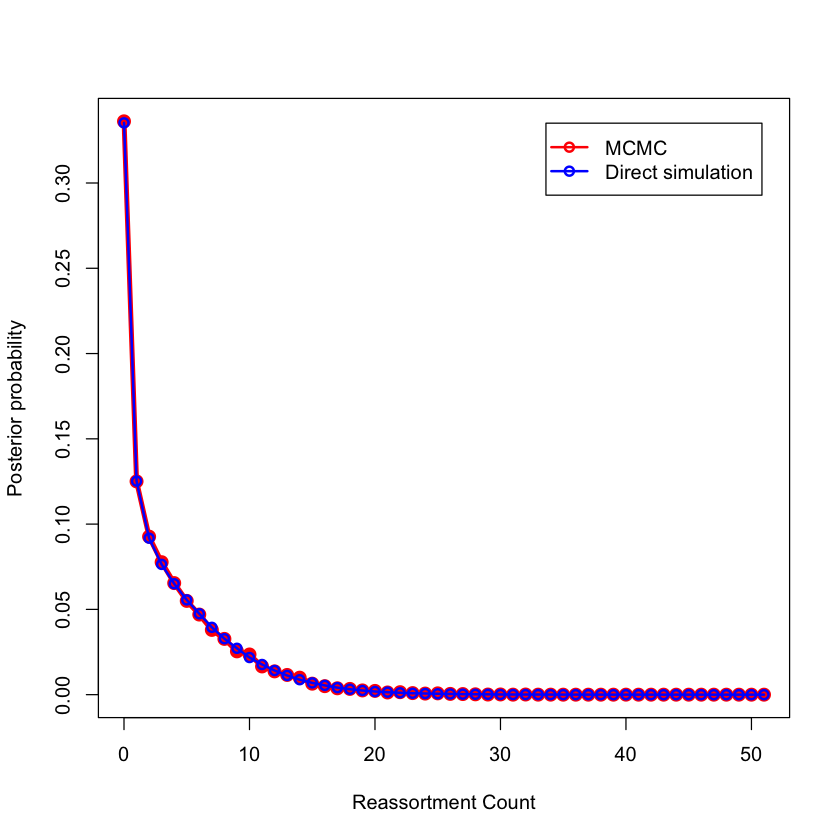

In [75]:
doCompare("simulate_contemp2taxon8seg.log",
          "testDivertSegment_contemp2taxon8seg.log")

# Add/Remove Operator Validation

## Two-taxon two-segment networks

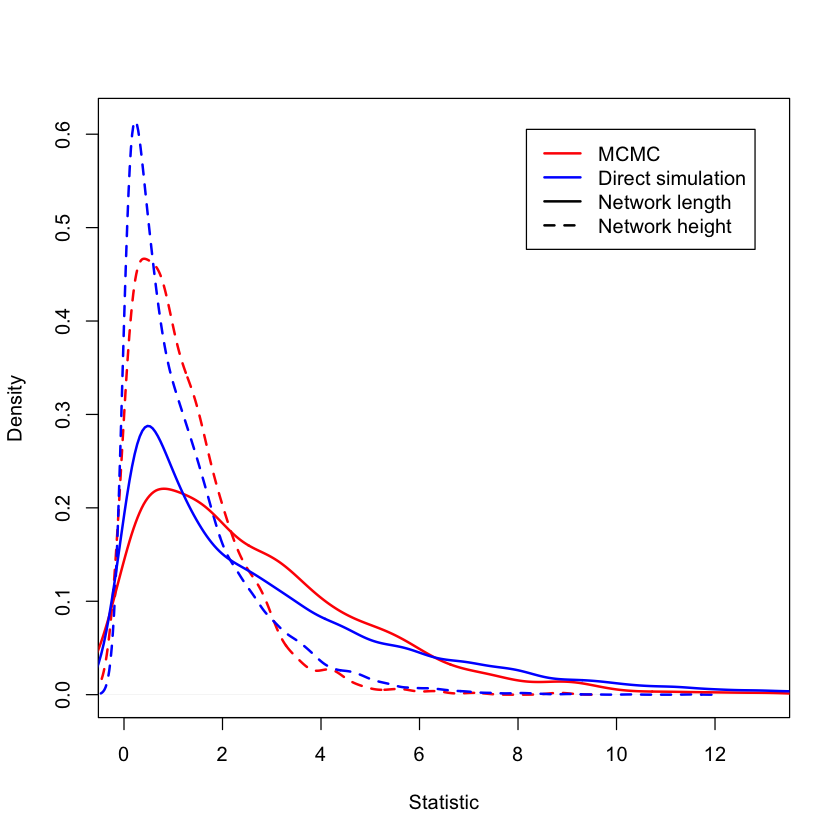

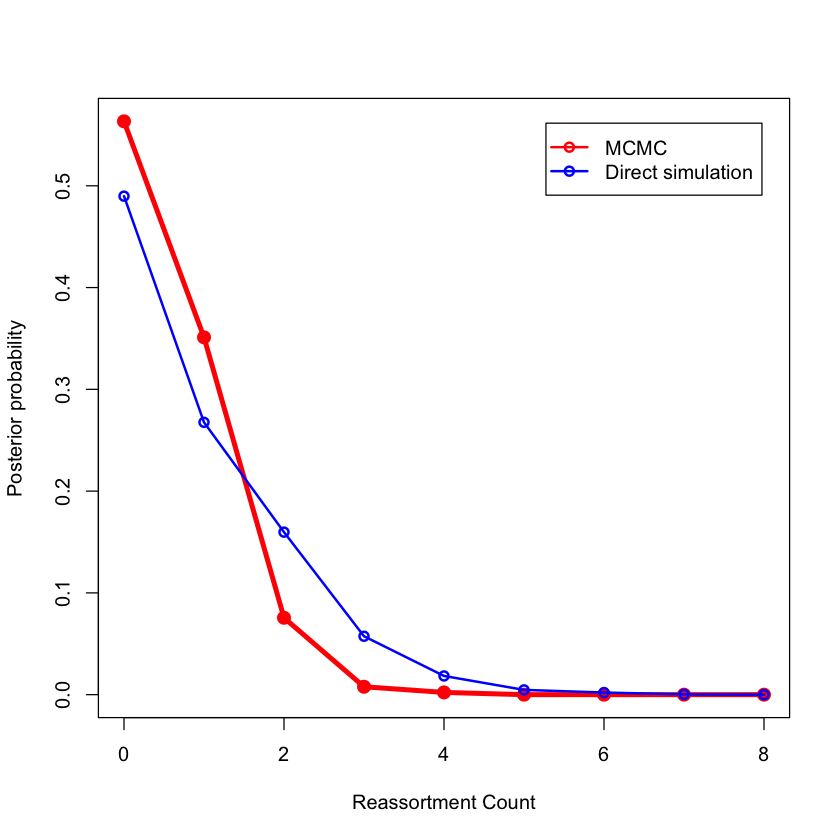

In [7]:
doCompare("simulate_contemp2taxon2seg.log",
          "testAddRemove_contemp2taxon2seg.log")